# Time Series From Scratch (part. 7) — Train/Test Splits and Evaluation Metrics (Dario Radečić)
[Source](https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37). From [Time Series From Scratch](https://towardsdatascience.com/tagged/time-series-from-scratch).

- Author: Israel Oliveira [\[e-mail\]](mailto:'Israel%20Oliveira%20'<prof.israel@gmail.com>)

In [1]:
%load_ext watermark

In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.grid'] = True
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5

In [8]:
# from tqdm import tqdm

# from glob import glob

# import matplotlib.pyplot as plt
# %matplotlib inline
# from IPython.core.pylabtools import figsize
# figsize(12, 8)

# import seaborn as sns
# sns.set_theme()

# pd.set_option("max_columns", None)
# pd.set_option("max_rows", None)
# pd.set_option('display.max_colwidth', None)

# from IPython.display import Markdown, display
# def md(arg):
#     display(Markdown(arg))

# from pandas_profiling import ProfileReport
# #report = ProfileReport(#DataFrame here#, minimal=True)
# #report.to

# import pyarrow.parquet as pq
# #df = pq.ParquetDataset(path_to_folder_with_parquets, filesystem=None).read_pandas().to_pandas()

# import json
# def open_file_json(path,mode='r',var=None):
#     if mode == 'w':
#         with open(path,'w') as f:
#             json.dump(var, f)
#     if mode == 'r':
#         with open(path,'r') as f:
#             return json.load(f)

# import functools
# import operator
# def flat(a):
#     return functools.reduce(operator.iconcat, a, [])

# import json
# from glob import glob
# from typing import NewType


# DictsPathType = NewType("DictsPath", str)


# def open_file_json(path):
#     with open(path, "r") as f:
#         return json.load(f)

# class LoadDicts:
#     def __init__(self, dict_path: DictsPathType = "./data"):
#         Dicts_glob = glob(f"{dict_path}/*.json")
#         self.List = []
#         self.Dict = {}
#         for path_json in Dicts_glob:
#             name = path_json.split("/")[-1].replace(".json", "")
#             self.List.append(name)
#             self.Dict[name] = open_file_json(path_json)
#             setattr(self, name, self.Dict[name])


In [9]:
# Run this cell before close.
%watermark -d --iversion -b -r -g -m -v
!cat /proc/cpuinfo |grep 'model name'|head -n 1 |sed -e 's/model\ name/CPU/'
!free -h |cut -d'i' -f1  |grep -v total

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.25.0

Compiler    : GCC 8.3.0
OS          : Linux
Release     : 5.11.0-7620-generic
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit

Git hash: 37d3a4de4336d1d67ee2c7ef766fa74155d1cda9

Git repo: https://github.com/ysraell/forecasting.git

Git branch: main

pandas    : 1.3.1
matplotlib: 3.4.2
numpy     : 1.19.5

CPU	: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz
Mem:           15G
Swap:         4.0G


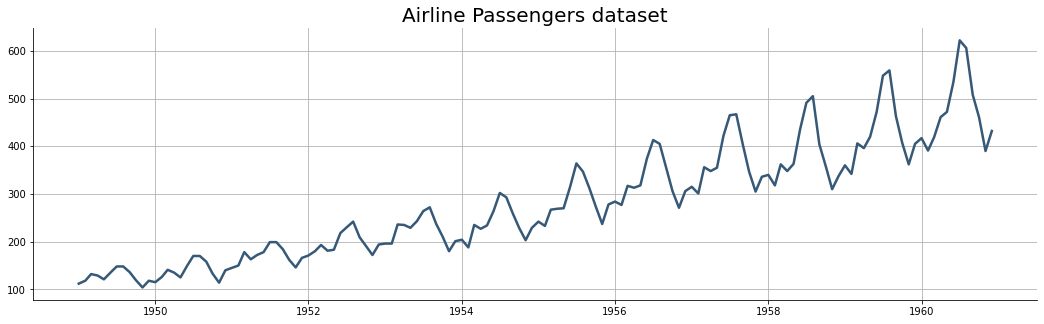

In [75]:
# Load
df = pd.read_csv('/work/tmp/airline-passengers.csv', index_col='Month', parse_dates=True)

# Visualize
plt.title('Airline Passengers dataset', size=20)
plt.plot(df);

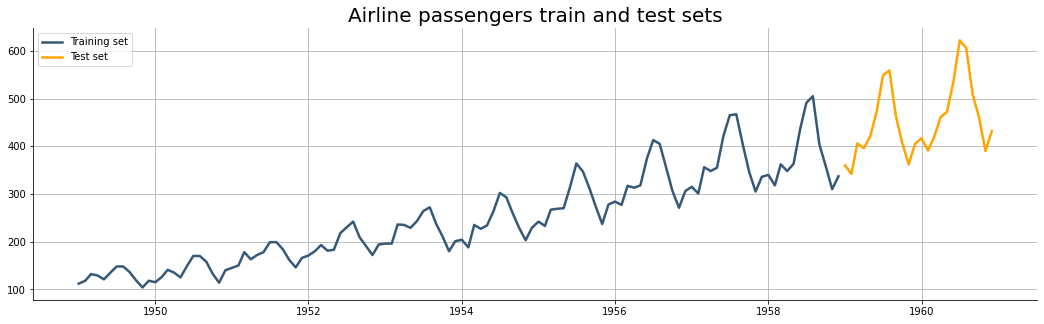

In [76]:

test_size = 24

df_train = df[:-test_size]
df_test = df[-test_size:]

plt.title('Airline passengers train and test sets', size=20)
plt.plot(df_train, label='Training set')
plt.plot(df_test, label='Test set', color='orange')
plt.legend();

In [12]:
rmse = lambda act, pred: np.sqrt(mean_squared_error(act, pred))

# Arbitrary data
actual_passengers = [300, 290, 320, 400, 500, 350]
predicted_passengers = [291, 288, 333, 412, 488, 344]

# Error metrics
print(f'RMSE: {rmse(actual_passengers, predicted_passengers)}')
print(f'MAPE: {mean_absolute_percentage_error(actual_passengers, predicted_passengers)}')

RMSE: 9.814954576223638
MAPE: 0.024777401477832514


In [15]:
from prophet import Prophet

In [30]:
df = df_train.reset_index().copy()
df.columns

Index(['Month', 'Passengers'], dtype='object')

In [31]:
df = df.rename(columns={"Month": "ds", "Passengers": "y"})
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [33]:
Prophet?

Init signature:
Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)
Docstring:     
Prophet forecaster.

Parameters
----------
growth: String 'linear' or 'logistic' to specify a linear or logistic
    trend.
changepoints: List of dates at which to include potential changepoints. If
    not specified, potential changepoints are selected automatically.
n_changepoints: Number of potential changepoints to include. Not used
    if input `changepoints` is supplied. If `changepoints` is not supplied,
    then n_changepoints potential changepoints are selected uniformly from
    the first `changepoint_range`

In [32]:
m = Prophet()
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.56207


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       331.978    3.8245e-06       57.4123      0.7195      0.7195      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       332.008   0.000234053       90.4455   2.747e-06       0.001      228  LS failed, Hessian reset 
     185       332.019   1.58676e-05       55.3598   2.453e-07       0.001      329  LS failed, Hessian reset 
     199       332.019    5.2363e-07       47.9962           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       332.019   2.39321e-09       59.3715      0.1463      0.1463      370   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [84]:
future = m.make_future_dataframe(periods=12 , freq='M')

In [66]:
future = pd.DataFrame()
future['ds'] = df_test.reset_index().Month

In [86]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
127,1959-07-31,482.578122,459.426584,507.156279
128,1959-08-31,447.503690,423.392248,470.893118
129,1959-09-30,415.558422,392.082910,438.323687
130,1959-10-31,386.601106,362.017800,411.553050
131,1959-11-30,414.354120,391.114003,438.899620


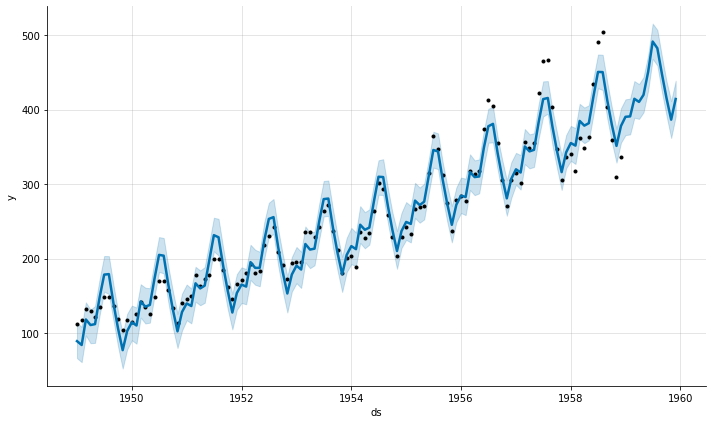

In [87]:
fig1 = m.plot(forecast)

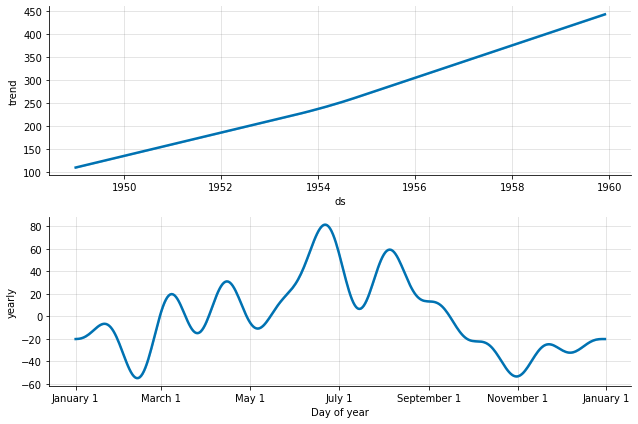

In [88]:
fig2 = m.plot_components(forecast)

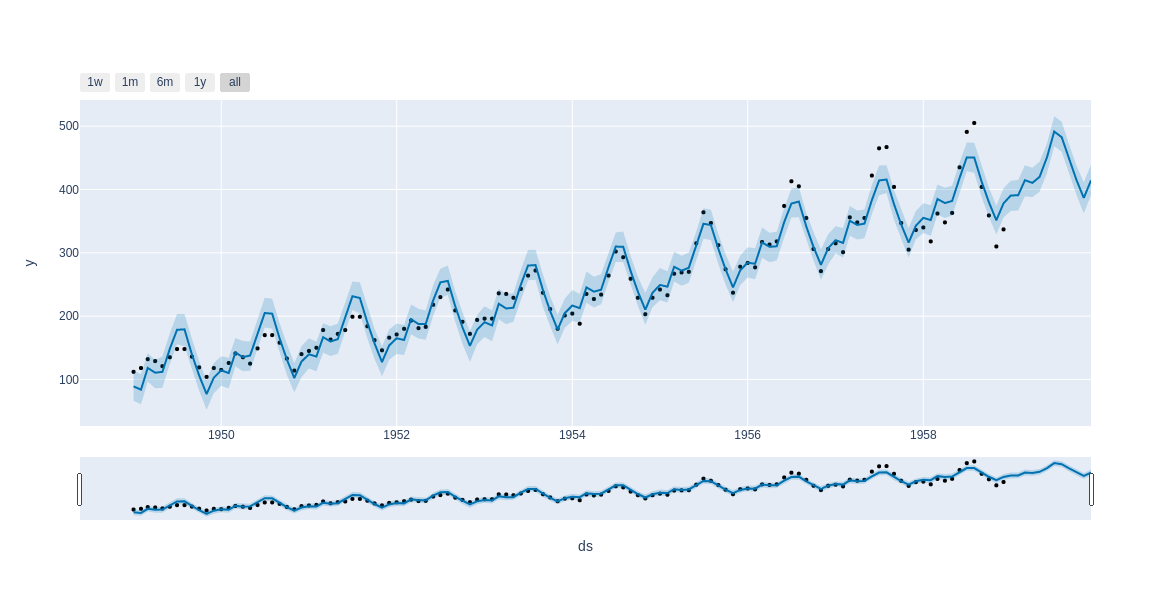

In [89]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

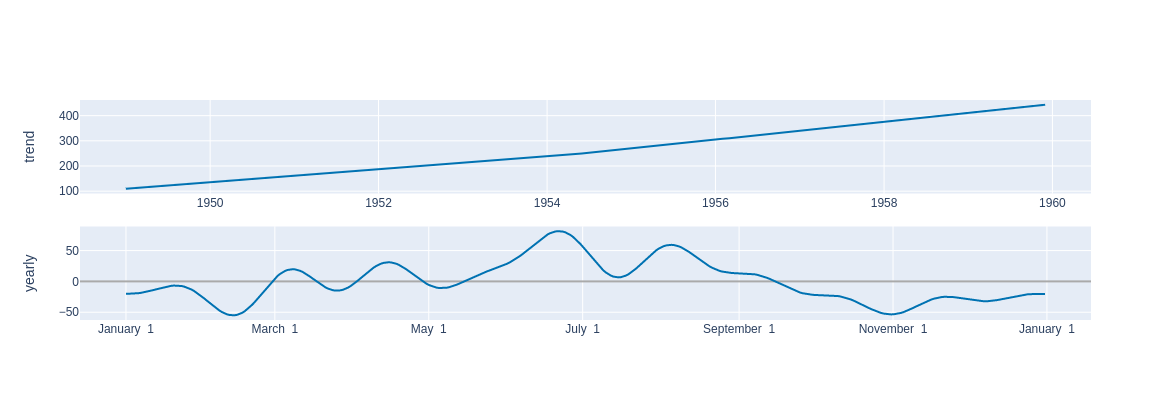

In [90]:
plot_components_plotly(m, forecast)


In [100]:
forecast_test = forecast.loc[forecast.ds > df_train.reset_index().Month.max()].copy()

In [101]:
df_hat = pd.DataFrame()
df_hat['Month'] = forecast_test['ds']
df_hat['Passengers'] = forecast_test['yhat']

In [102]:
df_hat = df_hat.set_index('Month')
df_hat.head()

,Passengers
Month,
1958-12-31,390.401113
1959-01-31,391.000323
1959-02-28,414.643459
1959-03-31,410.447290
1959-04-30,419.909998


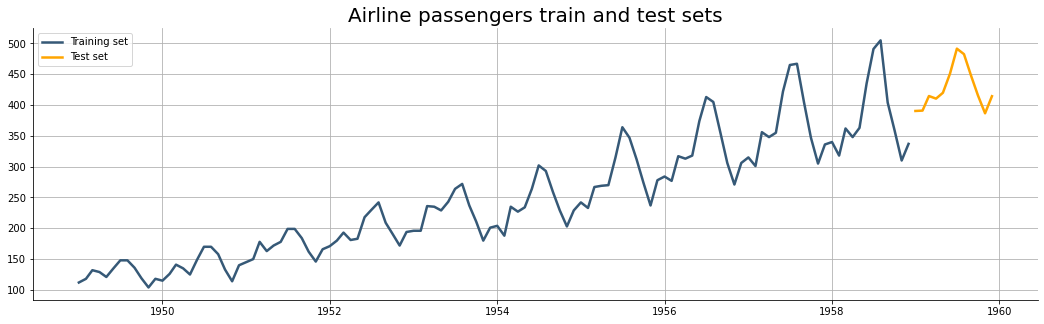

In [103]:
test_size = 24

plt.title('Airline passengers train and test sets', size=20)
plt.plot(df_train, label='Training set')
plt.plot(df_hat, label='Test set', color='orange')
plt.legend();